# ML.py, MLpy, MLPy!
<p style="text-align: center;">MLpy came as a simple question <i>and</i> a project in pespective:
<br><b>"Can I build a discord bot that can tell two pictures apart?"</b></p>
<br>The goal of this Jupyter Notebook is two-fold with one overarching thread:

1. To build a web crawler that can crawl a statistically relevant number of images from [derpibooru](https://derpibooru.org), a linear image database powered by the community revolving around the 'My Little Pony' G4 show.
2. To build a machine learning model capable of telling the difference between 2 types of pictures--to be summarized in a function to implement in my existing Discord bot [BotJack](https://github.com/LMquentinLR/botjack_discord_bot).

### Why image detection for a Discord bot?
A Discord moderation team may want to identify images posted on their server for multiple purposes: classification, tagging, games, etc. 
<p style="text-align: center;">This notebook will focus on <b>compliance</b>.</p> 

* Servers often have anti-NSFW (i.e. not safe for watch) rules where explicit, grim, and otherwise unwanted content is banned or curtailed to specific server channels.
* Moderation being volunteer-driven on Discord, malicious users may capitalize on idle, asleep, or away-from-keyboard moderators to engage in rule-breaking activities. More commonly, users may simply post a NSFW picture in a SFW-only channel. 
* A bot able to distinguish NSFW content from SFW helps fill in the breaches that may affect any moderation effort. A bot, for instance, could automatically alert moderators when a specific content is posted and start a moderating process prior to any human intervention.

> <b>Automatic content moderation and compliance is a current industry effort in social media (e.g. Facebook)</b>, making this notebook a real world application.

In [1]:
import collections
import derpi_get #datacrawler available here: https://github.com/LMquentinLR/derpi_get
import datetime
import json
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import LeakyReLU
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers. normalization import BatchNormalization
import os
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import random
from random import shuffle
import shutil
import time

Using TensorFlow backend.


### Building a web crawler
Derpibooru is a website dedicated to fan MLP art. It provides a REST API for rudimentary site functionality, It can be freely used by anyone wanting to produce tools for the site or other webapps that use Derpibooru-provided data.

<b>Derpibooru licensing rules</b>

"<i>Anyone can use it, users making abusively high numbers of requests may be asked to stop. Your application MUST properly cache, respect server-side cache expiry times. Your client MUST gracefully back off if requests fail (eg non-200 HTTP code), preferably exponentially or fatally.</i>"

A single image can be accessed through the following links:
1. <b>Embedded</b>: [../2072316](https://derpibooru.org/2072316)
2. <b>Default size</b>: [../img/view/2019/6/22/2072316.png](https://derpicdn.net/img/view/2019/6/22/2072316.png) 
3. <b>Small size</b>: [../img/view/2019/6/22/2072316_small.png](https://derpicdn.net/img/view/2019/6/22/2072316_small.png)
4. <b>Medium size</b>: [../img/view/2019/6/22/2072316_medium.png](https://derpicdn.net/img/view/2019/6/22/2072316_medium.png)
5. <b>Large size</b>: [../img/view/2019/6/22/2072316_large.png](https://derpicdn.net/img/view/2019/6/22/2072316_large.png)

The metadata of a single picture can be accessed through the following link:
* https://derpibooru.org/2072316.json

Each picture as the following list of attributes:
>id, created_at, updated_at, first_seen_at, score, comment_count, width, height, file_name, description, uploader, uploader_id, image, upvotes, downvotes, faves, tags, tag_ids, aspect_ratio, original_format, mime_type, sha512_hash, orig_sha512_hash, source_url, representations, is_rendered, is_optimized, interactions, spoilered

------------------

## Initializing object

In [2]:
obj = derpi_get.derpibooru_search()

## Crawling
1. Test #1 would retrieve all existing available picture metadata but will stop at the 10th requested page
2. Test #2 will retrieve all existing available picture metadata (can take up to 60h as at July 2019 if you crawl the full derpibooru database)

In [ ]:
#test #1
obj.change_search(instances = 10)
obj.crawl()

In [3]:
#test #2
obj.change_search(instances = "")
obj.crawl()

----|Entering Derpibooru Data Crawler code|----
You are requesting the derpibooru page starting with the id 2148201.
You are requesting the derpibooru page starting with the id 2148226.
You are requesting the derpibooru page starting with the id 2148251.
The crawler scraped the derpibooru metadata. The program will now close.
---------------|Exiting Program|---------------


From time to time, retrieved metadata (as a JSON) would be missing their tags value. The following method checks for existing missing tags and retrieve them from derpibooru.

In [4]:
obj.repair()

----|Repairing missing tags in stored JSON|----
There was an error during the JSON load of file derpibooru_metadata_103.json:
Expecting ':' delimiter: line 1 column 871265 (char 871264)
----------------|Tags repaired|----------------


## Retrieving IDs based on tag selection

The derpi_get search function takes a list of strings. Each string which must match the following format:

> "+tag" <i>or</i> "-tag"

> <b>+</b> indicates keeping the ID during search, <b>-</b> indicates removing the ID

The [at_least_one] variable indicates:
1. if <b>TRUE</b>: <b>Only</b> the IDs, which tags <b>contain at least one</b> of the items listed in the variable [tags] with a "+" prefix, will be retrieved
2. if <b>FALSE</b>: <b>Only</b> the IDs, which tags <b>contain all</b> of the items listed in the variable [tags] with a "+" prefix, will be retrieved

In [5]:
search_tags = ["+safe", "+rarijack"]
search_include = False
obj.change_search(tags = search_tags, at_least_one = search_include)

In [6]:
id_list = obj.retrieve_ids()

print(len(id_list))
print(type(id_list))
print("\nFirst five items retrieved:")
print(id_list[:5])

----|Retrieving IDs based on tag selection|----
----------------|IDs retrieved|----------------
3593
<class 'list'>

First five items retrieved:
[(1062, 'derpicdn.net/img/2012/1/21/1062/large.jpg'), (1027, 'derpicdn.net/img/2012/1/20/1027/large.png'), (12258, 'derpicdn.net/img/2012/6/20/12258/large.png'), (12255, 'derpicdn.net/img/2012/6/20/12255/large.png'), (12249, 'derpicdn.net/img/2012/6/20/12249/large.png')]


### Retrieving pictures based on retrieved IDs

In [7]:
nb_of_requests = len(id_list)
print(nb_of_requests)

3593


In [ ]:
obj.request_imgs(search_tags, id_list)

## Data Exploration Using MatPlotlib

#### What do we want to plot?

> number of "safe" pictures posted across time that fit the tag "rarijack".

In [9]:
obj.change_search(tags = ["+rarijack"], at_least_one = False)
rarijack = obj.retrieve_ids()
obj.change_search(tags = ["+rarilight"], at_least_one = False)
rarilight = obj.retrieve_ids()
obj.change_search(tags = ["+flarity"], at_least_one = False)
flarity = obj.retrieve_ids()
obj.change_search(tags = ["+raridash"], at_least_one = False)
raridash = obj.retrieve_ids()
obj.change_search(tags = ["+raripie"], at_least_one = False)
raripie = obj.retrieve_ids()

----|Retrieving IDs based on tag selection|----
----------------|IDs retrieved|----------------
----|Retrieving IDs based on tag selection|----
----------------|IDs retrieved|----------------
----|Retrieving IDs based on tag selection|----
----------------|IDs retrieved|----------------
----|Retrieving IDs based on tag selection|----
----------------|IDs retrieved|----------------
----|Retrieving IDs based on tag selection|----
----------------|IDs retrieved|----------------


### MatplotLib

In [10]:
ships = {"rarijack":rarijack,
        "rarilight":rarilight,
        "flarity":flarity,
        "raridash":raridash,
        "raripie":raripie}

In [11]:
def create_dataframe(name, data):
    """
    Creates the dataframe containing the data for each pairing in ships
    -----
    :param <name>: str ; name of pairing
    :param <data>: lists ; list of tuples containing the pairing data 
    """
    datelist = []
    for entry in data:
        url_split = entry[1].split("/")
        url_split = list(map(int, url_split[-5: -2]))
        datelist.append(datetime.date(url_split[0], url_split[1], url_split[2]))
    shipping_data = pd.DataFrame(data=dict(collections.Counter(datelist)).values(),
                                 index=collections.Counter(datelist))
    shipping_data.sort_index(inplace=True)
    shipping_data.index = pd.to_datetime(shipping_data.index)
    shipping_data = shipping_data.reindex(pd.date_range(shipping_data.index[0],shipping_data.index[-1]), 
                                          fill_value=0)
    shipping_data[1] = shipping_data.cumsum()
    shipping_data.columns = [name, "cumSum"]
    #print(shipping_data)
    return shipping_data

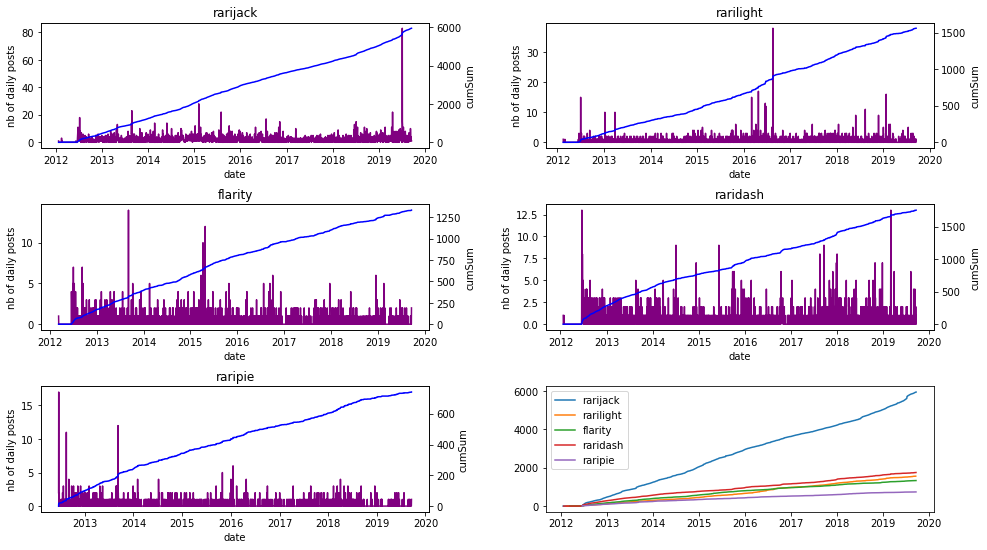

In [12]:
years = mdates.YearLocator() #every year
yearsFmt = mdates.DateFormatter("%Y")
#months = mdates.MonthLocator(interval=3) #every month
#months = mdates.DateFormatter("%y.%m")

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 9))
fig.subplots_adjust(hspace=.45, wspace=.3)

counter = 0
for i in range(3):
    for j in range(2):
        if i * j != 2:
            df = create_dataframe(list(ships.keys())[counter], ships[list(ships.keys())[counter]])
            axes[i, j].set_title(list(ships.keys())[counter])
            axes[i, j].plot(df.index, 
                            df[list(ships.keys())[counter]].values, 
                            color="purple", 
                            label=list(ships.keys())[counter])
            ax2 = axes[i, j].twinx()
            ax2.plot(df.index, 
                     df["cumSum"].values, 
                     color="blue")
            ax2.set_ylabel("cumSum")
            axes[i, j].set_xlabel("date")
            axes[i, j].set_ylabel("nb of daily posts")
            axes[i, j].xaxis.set_major_locator(years)
            axes[i, j].xaxis.set_major_formatter(yearsFmt)
            #axes[i, j].xaxis.set_minor_locator(months)
            #axes[i, j].xaxis.set_minor_formatter(monthsFmt)
            #axes[i, j].xaxis.set_major_locator(months)
            #axes[i, j].xaxis.set_major_formatter(monthsFmt) 
            axes[2, 1].plot(df.index, df["cumSum"].values,
                            label=list(ships.keys())[counter])
        counter += 1

axes[2, 1].xaxis.set_major_locator(years)
axes[2, 1].xaxis.set_major_formatter(yearsFmt)
axes[2, 1].legend()
plt.savefig('foo.png')

# SEPARATING SFW FROM NSFW PICTURES

## Downloading pictures

We need to download a set of pictures which can be used to fit a machine learning model.

In [13]:
def download(tags, nb_of_requests):
    """
    Downloads pictures based on a list of tag.
    ---
    :param <tags>: list ; list of tags to sort and download pictures
    :param <nb_of_requests>: int ; number of download requests to perform
    """
    for tag in tags:
        obj = derpi_get.derpibooru_search()
        obj.change_search(tags = tag, at_least_one = True)
        id_list = obj.retrieve_ids()
        obj.request_imgs(tag, id_list, nb_of_requests)

In [14]:
tags = [["+safe","-comic", "-meme", "-text"], 
        ["+explicit", "+grimdark", "+suggestive", "+questionable", "-comic", "-meme", "-text"]]

In [ ]:
download(tags, 5000)

## Cleaning extracted pictures

The retrieved pictures are all sized differently and some are unusable. We need to resize them and clean the folders from the unreadable data.

In [16]:
def clean_pictures(targets):
    """
    Cleans the pictures that will be used for training and validation.
    ---
    :param <targets>: list ; list of folders to clean
    """
    for folder in target_folders:
        img_content = os.listdir(folder)
        to_delete = []
        for img in img_content:
            if ((img[-4:] == "jpeg") or 
                (img[-3:] == "jpg") or 
                (img[-3:] == "png")):
                try:
                    image = Image.open(folder + "/" + img)
                    if 0.7 < image.size[0]/image.size[1] < 1.4:
                        image = image.resize((224, 224))
                        image.save(folder + "/" + img)
                    else:
                        image.close()
                        os.remove(folder + "/" + img)
                except Exception as e:
                    print(e)
                    os.remove(folder + "/" + img)

The downloaded pictures have been <b>manually</b> copied in "copy" folders to avoid overwriting them.

In [17]:
target_folders = ["./data/+safe-comic-meme-text", 
                  "./data/+explicit+grimdark+questionable+suggestive-comic-meme-text"]
clean_pictures(target_folders)

cannot write mode RGBA as JPEG


## Running Machine Learning

### Creating samples

Based on all the extracted pictures--and to make the process run in a timely manner on my Surface Pro 2--we are sampling the extracted data:

- 2000 safe and unsafe pictures for training
- 200 safe and unsafe pictures for testing/validation

In [18]:
def create_sample(folders, model_description):
    """
    Samples existing pictures.
    ---
    :param <folders>: list ; list of folders to sample
    :param <model_description>: list ; list of folders where to store samples 
                                 + nb of pictures to extract
    """
    for model in model_description:
        target_folder = model[0]
        try:
            shutil.rmtree(target_folder)
        except Exception as e: 
            print(e)
        os.makedirs(target_folder)
        
        selection = []
        
        for folder in folders:
            counter = 0
            stored_imgs = os.listdir(folder)
            
            while counter != model[1]:
                choice = random.choice(stored_imgs)
                if choice not in selection:
                    selection.append(choice)
                    shutil.copy(folder + "/" + choice, target_folder)
                    os.rename(target_folder + "/" + choice,
                             target_folder + "/" + folder[7:].split("-")[0]
                             + "-" + choice)
                    counter += 1

In [19]:
folders = ["./data/+safe-comic-meme-text", 
           "./data/+explicit+grimdark+questionable+suggestive-comic-meme-text"]
model_description = [("./data/train/Training", 2000),
                     ("./data/train/Test", 200)]

create_sample(folders, model_description)

[WinError 3] The system cannot find the path specified: './data/train/Training'
[WinError 3] The system cannot find the path specified: './data/train/Test'


The code below is a rewrite of the following github: [here](https://github.com/CShorten/KaggleDogBreedChallenge/blob/master/DogBreed_BinaryClassification.ipynb?source=post_page---------------------------).
Thanks to CShorten!

In [20]:
def label_img(name):
    """
    Returns whether an image is safe or unsafe based on its name.
    ---
    :param <name>: string ; path/name of a picture
    """
    word_label = name.split('-')[0]
    if word_label.startswith("+safe"): return np.array([1, 0])
    else: return np.array([0, 1])

def load_data(folder):
    """
    Loads the safe/unsafe value of each picture stored in a specific folder.
    ---
    :param <filder>: string ; path of a folder
    """
    test_data = []
    for img in os.listdir(folder):
        label = label_img(img)
        path = os.path.join(folder, img)
        img = Image.open(path)
        img = img.convert('L')
        img = img.resize((224, 224), Image.ANTIALIAS)
        test_data.append([np.array(img), label])
    shuffle(test_data)
    return test_data

In [21]:
model_description = [("./data/train/Training", 2000),
                     ("./data/train/Test", 200)]
DIR_TRAINING = model_description[0][0]
DIR_TESTING = model_description[1][0]

c:\users\quent\appdata\local\programs\python\python37\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


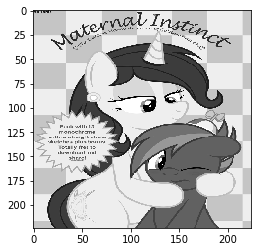

In [22]:
train_data = load_data(DIR_TRAINING)
plt.imshow(train_data[1][0], cmap = 'gist_gray')

trainImages = np.array([i[0] for i in train_data]).reshape(-1, 224, 224, 1)
trainLabels = np.array([i[1] for i in train_data])

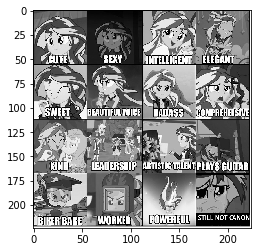

In [23]:
test_data = load_data(DIR_TESTING)    
plt.imshow(test_data[1][0], cmap = 'gist_gray')

testImages = np.array([i[0] for i in test_data]).reshape(-1, 224, 224, 1)
testLabels = np.array([i[1] for i in test_data])

### Machine Learning Modeling

In [24]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3),
                 activation='relu',
                 input_shape=(224, 224, 1)))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))

model.add(Conv2D(96,
                 kernel_size=(3,3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(96,
                 kernel_size=(3,3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64,
                 kernel_size=(3,3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(2, activation = 'softmax'))

W0920 04:42:54.123538  8388 deprecation_wrapper.py:119] From c:\users\quent\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0920 04:42:54.244319  8388 deprecation_wrapper.py:119] From c:\users\quent\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0920 04:42:54.268411  8388 deprecation_wrapper.py:119] From c:\users\quent\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0920 04:42:54.305500  8388 deprecation_wrapper.py:119] From c:\users\quent\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. P

In [25]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics = ['accuracy'])

W0920 04:42:55.158200  8388 deprecation_wrapper.py:119] From c:\users\quent\appdata\local\programs\python\python37\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0920 04:42:55.204163  8388 deprecation.py:323] From c:\users\quent\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [26]:
model.fit(trainImages, 
          trainLabels, 
          batch_size = 32, 
          epochs = 20,
          verbose = 1)

Epoch 1/20
4000/4000 [==============================] - 540s 135ms/step - loss: 1.3163 - acc: 0.5393
Epoch 2/20
4000/4000 [==============================] - 539s 135ms/step - loss: 0.7186 - acc: 0.5968
Epoch 3/20
4000/4000 [==============================] - 541s 135ms/step - loss: 0.6409 - acc: 0.6377
Epoch 4/20
4000/4000 [==============================] - 552s 138ms/step - loss: 0.5771 - acc: 0.6865
Epoch 5/20
4000/4000 [==============================] - 560s 140ms/step - loss: 0.5222 - acc: 0.7405
Epoch 6/20
4000/4000 [==============================] - 555s 139ms/step - loss: 0.4506 - acc: 0.7827
Epoch 7/20
4000/4000 [==============================] - 557s 139ms/step - loss: 0.3862 - acc: 0.8213
Epoch 8/20
4000/4000 [==============================] - 555s 139ms/step - loss: 0.3294 - acc: 0.8473
Epoch 9/20
4000/4000 [==============================] - 555s 139ms/step - loss: 0.2646 - acc: 0.8870
Epoch 10/20
4000/4000 [==============================] - 556s 139ms/step - loss: 0.2053 - a

In [27]:
loss, acc = model.evaluate(testImages, testLabels, verbose = 0)
print(acc * 100)

85.0


As at September 14th, the prediction power of the model over the test sample is of 85%.

In [28]:
model.save('NSFWdetector_20e32bs_v1.h5')

### Training an already trained model

2000 new safe and unsafe pictures have been sampled for training, along with 200 new safe and unsafe pictures for testing.

In [ ]:
tags = [["+safe","-comic", "-meme", "-text"], 
        ["+explicit", "+grimdark", "+suggestive", "+questionable", "-comic", "-meme", "-text"]]

download(tags, 5000)

folders = ["./data/+safe-comic-meme-text", 
                  "./data/+explicit+grimdark+questionable+suggestive-comic-meme-text"]
clean_pictures(target_folders)

In [30]:
model_description = [("./data/retrain/Training", 2000),
                     ("./data/retrain/Test", 200)]

create_sample(folders, model_description)

[WinError 3] The system cannot find the path specified: './data/retrain/Training'
[WinError 3] The system cannot find the path specified: './data/retrain/Test'


In [31]:
model = load_model('NSFWdetector_20e32bs_v1.h5')

In [32]:
model.fit(trainImages, 
          trainLabels, 
          batch_size = 32, 
          epochs = 10,
          verbose = 1)

Epoch 1/10
4000/4000 [==============================] - 559s 140ms/step - loss: 0.0708 - acc: 0.9728
Epoch 2/10
4000/4000 [==============================] - 556s 139ms/step - loss: 0.0507 - acc: 0.9810
Epoch 3/10
4000/4000 [==============================] - 556s 139ms/step - loss: 0.0514 - acc: 0.9822
Epoch 4/10
4000/4000 [==============================] - 562s 141ms/step - loss: 0.0544 - acc: 0.9810
Epoch 5/10
4000/4000 [==============================] - 559s 140ms/step - loss: 0.0563 - acc: 0.9810
Epoch 6/10
4000/4000 [==============================] - 571s 143ms/step - loss: 0.0579 - acc: 0.9800
Epoch 7/10
4000/4000 [==============================] - 559s 140ms/step - loss: 0.0384 - acc: 0.9868
Epoch 8/10
4000/4000 [==============================] - 558s 139ms/step - loss: 0.0407 - acc: 0.9873
Epoch 9/10
4000/4000 [==============================] - 560s 140ms/step - loss: 0.0526 - acc: 0.9830
Epoch 10/10
4000/4000 [==============================] - 560s 140ms/step - loss: 0.0614 - a

In [33]:
loss, acc = model.evaluate(testImages, testLabels, verbose = 0)
print(acc * 100)

87.5


As at September 20th, training the first version of the model again betters the prediction power of the model over a test sample by 250 basis points.

In [34]:
model.save('NSFWdetector_20e32bs_v1_retrained.h5')